<a href="https://colab.research.google.com/github/Alenushka2013/ML_for_people_tasks/blob/main/HW_2_2_3_Polynomial_features_Pipelines.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

В цьому домашньому завданні ми проведемо додаткові експерименти для рішення задачі бінарної класифікації і створимо ваш новий submission на змагання на Kaggle.

-----------


**Завдання 0**. Завантажте дані `train.csv`, `test.csv`, `sample_submission.csv` зі змагання на Kaggle - шукайте посилання в уроці [Запрошення до участі у Kaggle-змаганні.](https://data-loves.kwiga.com/courses/machine-learning-dlia-liudei/domashnie-zavdannia-zmagannia-z-kaggle)  Для завантаження потрібно долучитись до змагання (натиснути кнопку "Join").


**Завдання 1**. **Збираємо весь код з попереднього ДЗ в одному місці.** В лекційному ноутбуці `Логістична регресія з ScikitLearn. Повна ML задача.ipynb` ми познайомились з поняттям пайплайнів, а також я показала, як компактно виглядає рішення МЛ задачі, якщо ми зберемо весь код разом.

Оскільки ми далі будемо робити експерименти, які включають ті самі етапи попередньої обробки, але інше моделювання - буде зручно мати весь код компактно і під рукою. Тому зараз ми займемось збором коду до купи :) Після цього завдання для подальших експериментів ви можете перенести частини розвʼязку взагалі в окремий `.py` файл, аби було зручно імпортувати функції.

Зі свого рішення в попередньому домашньому завданні (`Логістична регресія з scikit learn.ipynb`) зберіть усі кроки розвʼязку задачі разом з використанням `sklearn.Pipeline` за прикладом з лекції.

Ваш код нижче має містити
1. Читання даних з файлу (поза пайплайном).
2. Розбиття на тренувальний і валідаційний набори, де валідаційний містить 20% даних (поза пайплайном).
3. Виділення категоріальних і числових колонок (поза пайплайном).
4. Підготовку категоріальних і числових колонок (частина пайплайну). В прикладі в лекції ми оформлювали обробку числових і категоріальних колонок в окремі трансформери `numeric_transformer`, `categorical_cols`. Рекоемндую зробити саме так, так потім зручніше вносити зміни :)
5. Тренування лог регресії (частина пайплайну).
6. Запуск пайплайну на тренування на трен. даних (поза пайплайном).
7. Запуск пайплайну на передбачення на трен і вал. даних і вимір метрик якості ROC-AUC + вивдення Confusion Matrix (поза пайплайном).
8. Збереження моделі в формат joblib (поза пайплайном).

Ви це все вже зробили в попереднтьому ДЗ! Тож, тут просто заадча все зібрати разом.

Нижче я додала підказки, що покроково ви маєте зробити. Якщо ви почуваєтесь впевнено, можете видалити ці підказки і реалізувати все самостійно, або ж - просто заповнити пропуски.

Завдання оцінюється в 10 балів. Головний результат - аби код в фіналі був робочий. Бо за не робочий нам гроші ніхто не заплатить :)

In [1]:
import pandas as pd
import numpy as np
#from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import f1_score, confusion_matrix, roc_auc_score, classification_report, root_mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

Area under ROC score on Training dataset: 0.83


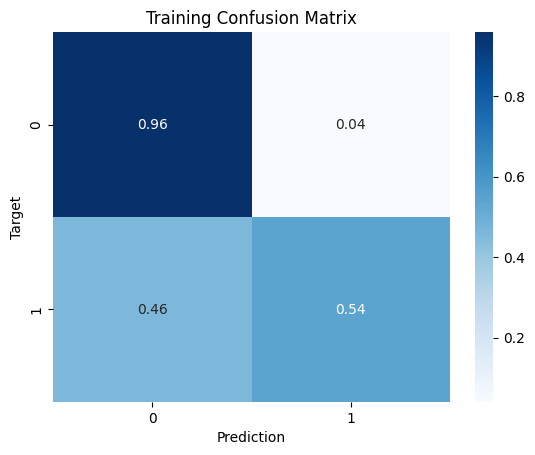

Area under ROC score on Validation dataset: 0.82


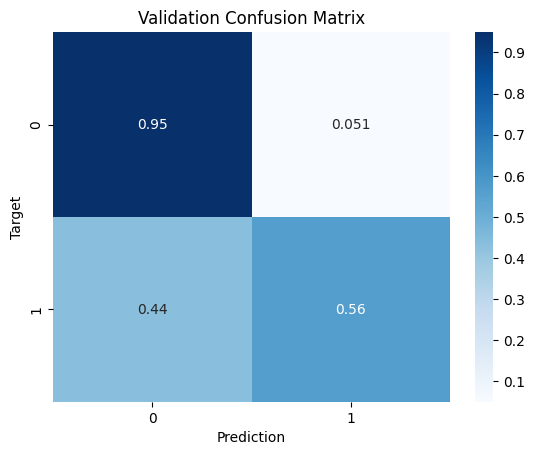

              precision    recall  f1-score   support

         0.0       0.90      0.95      0.92      2390
         1.0       0.74      0.56      0.64       610

    accuracy                           0.87      3000
   macro avg       0.82      0.76      0.78      3000
weighted avg       0.86      0.87      0.86      3000



['bank-customer_pipeline.joblib']

In [2]:
raw_df = pd.read_csv('https://raw.githubusercontent.com/Alenushka2013/Coursera/refs/heads/master/Datasets/bank-customer-churn-prediction.csv', index_col=0)

train_df, val_df = train_test_split(raw_df, test_size=0.2, random_state=42, stratify=raw_df['Exited'])

# Створюємо трен. і вал. набори
input_cols = list(train_df.columns)[2:-1]
target_col = 'Exited'
train_inputs, train_targets = train_df[input_cols], train_df[target_col]
val_inputs, val_targets = val_df[input_cols], val_df[target_col]

# Виявляємо числові і категоріальні колонки
numeric_cols = train_inputs.select_dtypes(include=np.number).columns.tolist()[:-1]
categorical_cols = train_inputs.select_dtypes(include='object').columns.tolist()

# Створюємо трансформери для числових і категоріальних колонок
numeric_transformer = Pipeline(steps=[
    ('scaler', MinMaxScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(sparse_output=False, handle_unknown='ignore'))
])

# Комбінуємо трансформери для різних типів колонок в один препроцесор
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# Стоврюємо пайплайн, який спочатку запускає препроцесинг, потім тренуєм модель
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(solver='liblinear'))
])

# Тренуємо пайплайн
model_pipeline.fit(train_inputs, train_targets)

# Функція, щоб передбачати і рахувати метрики
def predict_and_plot(model_pipeline, inputs, targets, name=''):
    preds = model_pipeline.predict(inputs)
    roc_auc = roc_auc_score(preds, targets)
    print(f"Area under ROC score on {name} dataset: {roc_auc:.2f}")
    confusion_matrix_ = confusion_matrix(targets, preds, normalize='true')
    plt.figure()
    sns.heatmap(confusion_matrix_, annot=True, cmap='Blues')
    plt.xlabel('Prediction')
    plt.ylabel('Target')
    plt.title('{} Confusion Matrix'.format(name))
    plt.show()
    return preds

# Оцінюємо модель на трен і вал даних
train_preds = predict_and_plot(model_pipeline, train_inputs, train_targets, 'Training')
val_preds = predict_and_plot(model_pipeline, val_inputs, val_targets, 'Validation')

# Звіт про класифікацію
print(classification_report(val_targets, model_pipeline.predict(val_inputs)))

# Зберігаємо модель для подальшого використання
joblib.dump(model_pipeline, 'bank-customer_pipeline.joblib')


**Завдання 2**. Такс, у нас з вами є вже готовий пайплайн. Давайте проведемо нові експерименти.

  Додайте в попередню обробку числових колонок генерацію polinomal features до степені 2 включно. Для цього створіть новий препроцесор і створіть новий пайплайн.

  Запустіть пайплайн на тренування і виведіть метрики для тренувального і валідаційного набору. Напишіть, як вам модель? Чи спостерігається в цій моделі overfit чи underfit? Чи ця модель добре генералізує?

Area under ROC score on Training dataset: 0.86


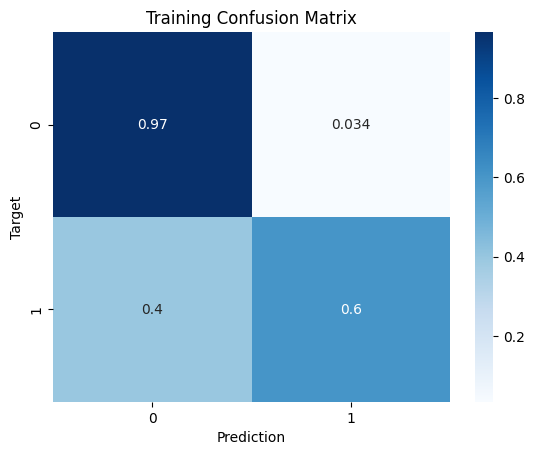

Area under ROC score on Validation dataset: 0.84


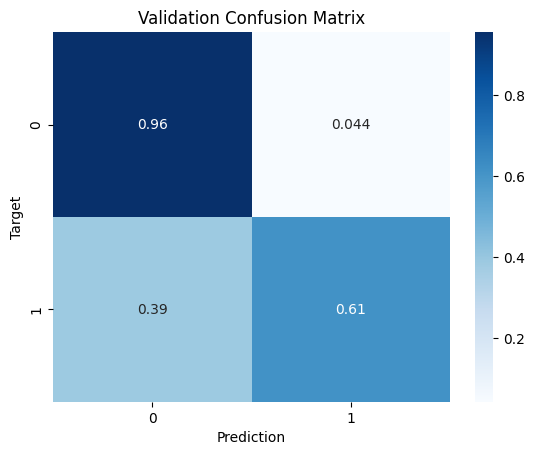

              precision    recall  f1-score   support

         0.0       0.91      0.96      0.93      2390
         1.0       0.78      0.61      0.69       610

    accuracy                           0.89      3000
   macro avg       0.84      0.78      0.81      3000
weighted avg       0.88      0.89      0.88      3000



['bank-customer_pipeline_pol2.joblib']

In [3]:
import operator
from sklearn.preprocessing import PolynomialFeatures

# Створюємо трансформери для числових і категоріальних колонок колонок
numeric_transformer = Pipeline(steps=[
    ('scaler', MinMaxScaler()),
    ('polynomial_features', PolynomialFeatures(degree=2))
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(sparse_output=False, handle_unknown='ignore'))
])

# Комбінуємо трансформери для різних типів колонок в один препроцесор
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# Стоврюємо пайплайн, який спочатку запускає препроцесинг, потім тренуєм модель
model_pipeline_pol2 = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(solver='liblinear'))
])

# Тренуємо пайплайн
model_pipeline_pol2.fit(train_inputs, train_targets)

# Оцінюємо модель на трен і вал даних
train_preds = predict_and_plot(model_pipeline_pol2, train_inputs, train_targets, 'Training')
val_preds = predict_and_plot(model_pipeline_pol2, val_inputs, val_targets, 'Validation')

# Звіт про класифікацію
print(classification_report(val_targets, model_pipeline_pol2.predict(val_inputs)))

# Зберігаємо модель для подальшого використання
joblib.dump(model_pipeline_pol2, 'bank-customer_pipeline_pol2.joblib')

**Висновки:**

Модель має показники метрик трохи кращі за попередню. Оскільки метрики на тренувальних і валідаційних даних близькі за значеннями, то overfit чи underfit не спостерігається.

Чи ця модель добре генералізує? З одного боку показники метрик достатньо високі, а з іншого передбачення тільки 61% класу "1" недостатньо, хотілося б краще.

**Завдання 3**. Тепер давайте створимо ще новий пайплайн, тільки тепер поліноміальні ознаки згенеруємо до степені 4. Зробіть висновок про якість моделі. Якщо вам подобається резульат якоїсь з моделей в цьому ДЗ - рекомендую зробити submission в змаганні.

Area under ROC score on Training dataset: 0.87


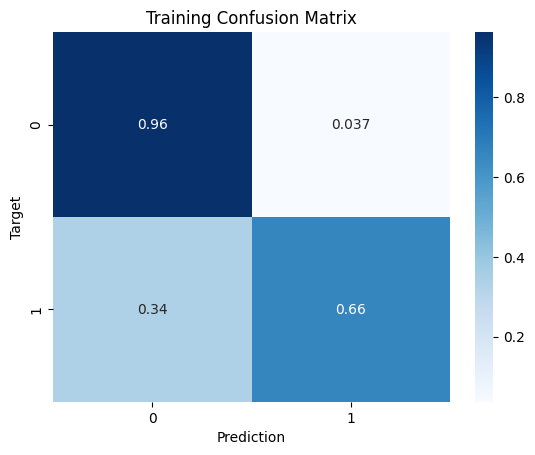

Area under ROC score on Validation dataset: 0.86


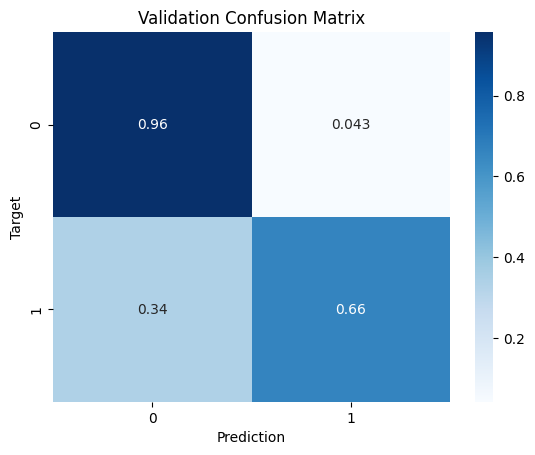

              precision    recall  f1-score   support

         0.0       0.92      0.96      0.94      2390
         1.0       0.80      0.66      0.72       610

    accuracy                           0.90      3000
   macro avg       0.86      0.81      0.83      3000
weighted avg       0.89      0.90      0.89      3000



['bank-customer_pipeline_pol4.joblib']

In [4]:
# Створюємо трансформери для числових колонок
numeric_transformer = Pipeline(steps=[
    ('scaler', MinMaxScaler()),
    ('polynomial_features', PolynomialFeatures(degree=4))
])

# Комбінуємо трансформери для різних типів колонок в один препроцесор
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# Стоврюємо пайплайн, який спочатку запускає препроцесинг, потім тренуєм модель
model_pipeline_pol4 = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(solver='liblinear'))
])

# Тренуємо пайплайн
model_pipeline_pol4.fit(train_inputs, train_targets)

# Оцінюємо модель на трен і вал даних
train_preds = predict_and_plot(model_pipeline_pol4, train_inputs, train_targets, 'Training')
val_preds = predict_and_plot(model_pipeline_pol4, val_inputs, val_targets, 'Validation')

# Звіт про класифікацію
print(classification_report(val_targets, model_pipeline_pol4.predict(val_inputs)))

# Зберігаємо модель для подальшого використання
joblib.dump(model_pipeline_pol4, 'bank-customer_pipeline_pol4.joblib')

**Висновки:**

Якість моделі стала ще кращою, overfit чи underfit все ще не спостерігаються.

Передбачається правильно 66% класу "1". Потрібно ще подумати як покращити цей показник.

**Завдання 4. Перенавчання і регуляризація**.

  Скачайте набір даних `regression_data.csv`. Звичайте набір даних з `regression_data.csv`, розбийте на train і test (в тест 20%) і натренуйте модель лінійної регресії з масштабуванням числових ознак і поліноміальними ознаками до степені **5 включно**.

  Виміряйте якість прогностичної моделі і зробіть висновок, чи модель хороша, чи вона добре генералізує?


In [5]:
regression_data = pd.read_csv('/content/regression_data.csv')
regression_data.head()

,feature_1,feature_2,feature_3,feature_4,feature_5,target
0,-0.190339,-1.382800,-0.875618,0.538910,-1.037246,28.938854
1,-0.321386,-0.563725,0.412931,-0.147057,-0.825497,-7.664581
2,2.122156,-1.519370,1.032465,-1.260884,0.917862,-63.845482
3,-1.380101,-0.055548,-1.703382,0.074095,1.628616,4.076259
4,-0.072829,-1.514847,-0.846794,0.714000,0.473238,34.879013


In [6]:
regression_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129 entries, 0 to 128
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   feature_1  129 non-null    float64
 1   feature_2  129 non-null    float64
 2   feature_3  129 non-null    float64
 3   feature_4  129 non-null    float64
 4   feature_5  129 non-null    float64
 5   target     129 non-null    float64
dtypes: float64(6)
memory usage: 6.2 KB


In [7]:
regression_data.describe()

,feature_1,feature_2,feature_3,feature_4,feature_5,target
count,129.000000,129.000000,129.000000,129.000000,129.000000,129.000000
mean,-0.082039,-0.017872,0.092293,-0.076084,0.053098,-3.902984
std,0.941214,1.065887,0.978557,0.910588,1.004498,45.466621
min,-3.241267,-2.619745,-1.913280,-2.211135,-2.301921,-111.753810
25%,-0.699726,-0.756351,-0.553649,-0.730367,-0.772825,-37.339533
50%,-0.066080,-0.161286,0.120296,0.018418,0.013002,-0.641298
75%,0.529804,0.679598,0.624120,0.519347,0.787085,25.464414
max,2.122156,3.852731,3.078881,2.314659,2.075401,115.125907


In [8]:
X = regression_data.drop('target',axis=1)
y = regression_data['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [9]:
def train_lin_vs_poly_reg_and_plot(X_train, X_val, y_train, y_val, degree):
  # Звичайна лінійна регресія
  lin_reg = LinearRegression()
  lin_reg.fit(X_train, y_train)
  y_pred_train_lin = lin_reg.predict(X_train)
  y_pred_val_lin = lin_reg.predict(X_val)

  # Поліноміальна регресія
  poly_features = PolynomialFeatures(degree=degree)
  X_train_poly = poly_features.fit_transform(X_train)
  X_val_poly = poly_features.transform(X_val)

  print(f'В оригіналній матриці Х {X.shape[1]} ознак.')
  print(f'В матриці Х з поліноміальними ознаками {X_train_poly.shape[1]} ознак.\n')

  poly_reg = LinearRegression()
  poly_reg.fit(X_train_poly, y_train)
  y_pred_train_poly = poly_reg.predict(X_train_poly)
  y_pred_val_poly = poly_reg.predict(X_val_poly)

  # Оцінка моделей

  rmse_lin_train = root_mean_squared_error(y_train, y_pred_train_lin)
  rmse_poly_train = root_mean_squared_error(y_train, y_pred_train_poly)

  r2_lin_train = r2_score(y_train, y_pred_train_lin)
  r2_poly_train = r2_score(y_train, y_pred_train_poly)

  rmse_lin_val = root_mean_squared_error(y_val, y_pred_val_lin)
  rmse_poly_val = root_mean_squared_error(y_val, y_pred_val_poly)

  r2_lin_val = r2_score(y_val, y_pred_val_lin)
  r2_poly_val = r2_score(y_val, y_pred_val_poly)


  print(f"Train RMSE for Linear Regression: {np.sqrt(rmse_lin_train):.4f}")
  print(f"Test RMSE for Linear Regression: {np.sqrt(rmse_lin_val):.4f}\n")

  print(f'Train R2 for Linear Regression: {r2_lin_train:.4f}')
  print(f'Test R2 for Linear Regression: {r2_lin_val:.4f}\n')

  print(f"Train RMSE for Polynomial Regression (degree {degree}): {np.sqrt(rmse_poly_train):.4f}")
  print(f"Test RMSE for Polynomial Regression (degree {degree}): {np.sqrt(rmse_poly_val):.4f}\n")

  print(f'Train R2 for Polynomial Regression (degree {degree}): {r2_poly_train:.4f}')
  print(f'Test R2 for Polynomial Regression (degree {degree}): {r2_poly_val:.4f}')

In [10]:
train_lin_vs_poly_reg_and_plot(X_train, X_test, y_train, y_test, degree = 5)

В оригіналній матриці Х 5 ознак.
В матриці Х з поліноміальними ознаками 252 ознак.

Train RMSE for Linear Regression: 1.0327
Test RMSE for Linear Regression: 0.9399

Train R2 for Linear Regression: 0.9994
Test R2 for Linear Regression: 0.9997

Train RMSE for Polynomial Regression (degree 5): 0.0000
Test RMSE for Polynomial Regression (degree 5): 5.4253

Train R2 for Polynomial Regression (degree 5): 1.0000
Test R2 for Polynomial Regression (degree 5): 0.6287


In [11]:
print('Для масштабованих ознак: MinMaxScaler')
MinMax = MinMaxScaler()
X_train_mm = MinMax.fit_transform(X_train)
X_test_mm = MinMax.transform(X_test)

train_lin_vs_poly_reg_and_plot(X_train_mm, X_test_mm, y_train, y_test, degree = 5)

Для масштабованих ознак: MinMaxScaler
В оригіналній матриці Х 5 ознак.
В матриці Х з поліноміальними ознаками 252 ознак.

Train RMSE for Linear Regression: 1.0327
Test RMSE for Linear Regression: 0.9399

Train R2 for Linear Regression: 0.9994
Test R2 for Linear Regression: 0.9997

Train RMSE for Polynomial Regression (degree 5): 0.0000
Test RMSE for Polynomial Regression (degree 5): 4.1652

Train R2 for Polynomial Regression (degree 5): 1.0000
Test R2 for Polynomial Regression (degree 5): 0.8710


**Висновки:**

Модель лінійної регресії гарно відпрацьовує як з масштабованими так і не масштабованими даними. Високі значення R2 та низькі значення RMSE, відносно середнього значення та стандартного відхилення.

Лінійна регресія з поліноміальними ознаками має ознаки перенавчання, високе значення R2, низьке значення RMSE на тренувальних даних та помітно менше значення  R2 та високе значення RMSE на тестових даних. Користуватися такою моделлю не варто.

**Завдання 5**. Натренуйте моделі Lasso(), Ridge(), ElasaticNet() на цих даних (з поліном ознаками до степені 20 включно), порівняйте якість з тою, яка була отримана з лінійною регресією. Яка модель найкраще генералізує і чому на ваш погляд (можливо треба буде для відповіді зробити додатковий аналіз ознак)?

In [12]:
from sklearn.linear_model import Ridge, Lasso, ElasticNet
models = [
    LinearRegression(),
    Ridge(max_iter=10000),
    Ridge(alpha=0.02),
    Lasso(alpha = 0.0001),
    ElasticNet(),
    ElasticNet(alpha=0.00005)
]

In [13]:
def evaluate_model(model, X_train, y_train, X_test, y_test):
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    train_metrics = round(root_mean_squared_error(y_train, y_train_pred),6)
    test_metrics = round(root_mean_squared_error(y_test, y_test_pred), 6)

    return dict(train=train_metrics, test=test_metrics)

In [14]:
poly_features = PolynomialFeatures(degree=20)
X_train_poly = poly_features.fit_transform(X_train)
X_test_poly = poly_features.transform(X_test)

MinMax_poly = MinMaxScaler()
X_train_poly_mm = MinMax_poly.fit_transform(X_train_poly)
X_test_poly_mm = MinMax_poly.transform(X_test_poly)

In [15]:
import warnings

warnings.filterwarnings("ignore")

for model in models:
    model.fit(X_train_poly_mm, y_train)
    eval_results  = evaluate_model(model, X_train_poly_mm, y_train, X_test_poly_mm, y_test)
    print(f'{str(model)}: {eval_results}\n')

LinearRegression(): {'train': 0.0, 'test': 15.674311}

Ridge(max_iter=10000): {'train': 8.59775, 'test': 76.562708}

Ridge(alpha=0.02): {'train': 0.630114, 'test': 21.358479}

Lasso(alpha=0.0001): {'train': 0.233066, 'test': 6.355759}

ElasticNet(): {'train': 34.179765, 'test': 116.029707}

ElasticNet(alpha=5e-05): {'train': 0.196458, 'test': 7.577946}



**Висновки:**

З поліноміальними ознаками до 20 степені всі моделі виявляють ознаки перенавчання, оскільки RMSE на тестових даних значно більше значень на тренувальних.

Модель Lasso показує трохи кращі результати за рахунок того, що відкидає частину від великої кількості утворених поліноміальних ознак.